<a href="https://colab.research.google.com/github/KavindaKGD/DL_Final_Assignment/blob/dev%2FMigara/LSTM_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Oct 10 08:26:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Basic libraries
import os, glob, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -q "/content/drive/MyDrive/street_building_dataset.zip" -d "/content/dataset"

In [59]:
import os
for root, dirs, files in os.walk("/content/dataset/street_building_dataset"):
    print(root, "->", len(files), "files")

/content/dataset/street_building_dataset -> 0 files
/content/dataset/street_building_dataset/train -> 0 files
/content/dataset/street_building_dataset/train/buildings -> 2191 files
/content/dataset/street_building_dataset/train/streets -> 2382 files
/content/dataset/street_building_dataset/test -> 0 files
/content/dataset/street_building_dataset/test/buildings -> 437 files
/content/dataset/street_building_dataset/test/streets -> 501 files


In [60]:
DATA_ROOT = "/content/dataset/street_building_dataset"

In [61]:
IMG_H, IMG_W = 150, 150
BATCH_SIZE = 32

In [62]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/train",
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/test",
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 4573 files belonging to 2 classes.
Found 938 files belonging to 2 classes.
Classes: ['buildings', 'streets']


In [63]:
AUTOTUNE = tf.data.AUTOTUNE

def rgb_to_seq(images, labels):
    images = tf.image.rgb_to_grayscale(images)
    images = tf.cast(images, tf.float32) / 255.0
    images = tf.squeeze(images, axis=-1)  # (batch, H, W)
    return images, labels

train_ds = train_ds.map(rgb_to_seq, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(rgb_to_seq, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

In [74]:
from tensorflow.keras import layers, models, Input

timesteps = IMG_H
features = IMG_W

inputs = Input(shape=(timesteps, features))
x = layers.LSTM(128)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       142,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,169 (590.50 KB)

 Trainable params: 151,169 (590.50 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_lstm.keras", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6791 - loss: 0.6029 - val_accuracy: 0.7260 - val_loss: 0.5625
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6990 - loss: 0.5844 - val_accuracy: 0.7292 - val_loss: 0.5522
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7048 - loss: 0.5803 - val_accuracy: 0.7260 - val_loss: 0.5656
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7098 - loss: 0.5718 - val_accuracy: 0.7303 - val_loss: 0.5476
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7132 - loss: 0.5634 - val_accuracy: 0.7132 - val_loss: 0.5584
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7033 - loss: 0.5761 - val_accuracy: 0.7196 - val_loss: 0.5578
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7139 - loss: 0.5709 - val_accuracy: 0.7324 - val_loss: 0.5442
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7110 - loss: 0.5672 - val_accu

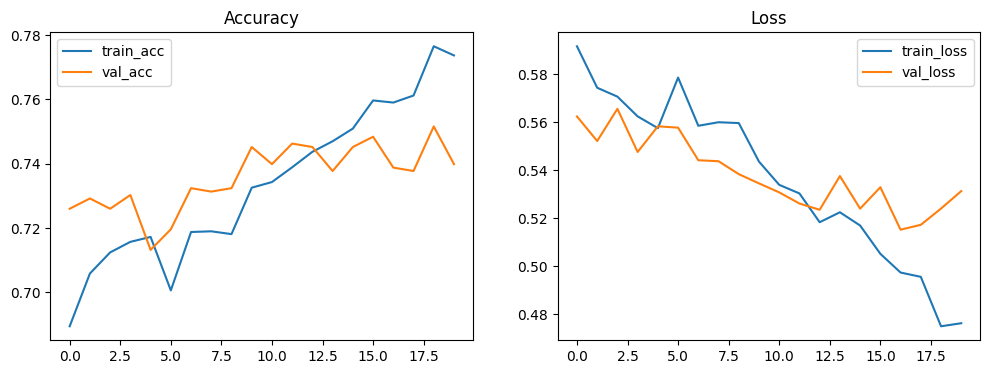

In [79]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.show()

In [91]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.3f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7373 - loss: 0.5099
Test Accuracy: 0.739


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

   buildings       0.72      0.73      0.72       437
     streets       0.76      0.75      0.75       501

    accuracy                           0.74       938
   macro avg       0.74      0.74      0.74       938
weighted avg       0.74      0.74      0.74       938



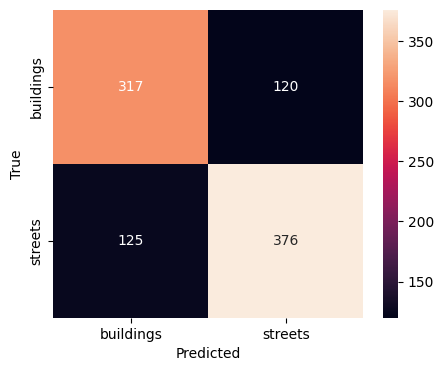

In [92]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = (y_prob.flatten() >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

In [101]:
model.save("/content/drive/MyDrive/best_lstm_street_building.keras")

In [96]:
!unzip -q "/content/dataset/pred.zip" -d "/content/dataset/pred"

In [97]:
pred_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/pred/pred",
    labels=None,              # unlabeled
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False
)

pred_ds = pred_ds.map(lambda x: tf.image.rgb_to_grayscale(x)/255.0).cache()

Found 938 files.


In [98]:
pred_prob = model.predict(pred_ds)
pred_class = (pred_prob.flatten() >= 0.5).astype(int)  # 0 = first class, 1 = second class

# Convert numeric predictions to class names
pred_labels = [class_names[i] if i < len(class_names) else "unknown" for i in pred_class]

for i, label in enumerate(pred_labels[:50]):  # show first 50
    print(f"Image {i+1}: {label}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Image 1: buildings
Image 2: buildings
Image 3: buildings
Image 4: buildings
Image 5: buildings
Image 6: streets
Image 7: streets
Image 8: streets
Image 9: buildings
Image 10: buildings
Image 11: streets
Image 12: buildings
Image 13: buildings
Image 14: streets
Image 15: streets
Image 16: streets
Image 17: streets
Image 18: streets
Image 19: streets
Image 20: buildings
Image 21: buildings
Image 22: streets
Image 23: streets
Image 24: buildings
Image 25: streets
Image 26: buildings
Image 27: buildings
Image 28: streets
Image 29: streets
Image 30: streets
Image 31: buildings
Image 32: buildings
Image 33: buildings
Image 34: streets
Image 35: streets
Image 36: buildings
Image 37: buildings
Image 38: streets
Image 39: buildings
Image 40: buildings
Image 41: buildings
Image 42: streets
Image 43: buildings
Image 44: streets
Image 45: streets
Image 46: buildings
Image 47: streets
Image 48: streets
Image 49: streets
Image 50: streets


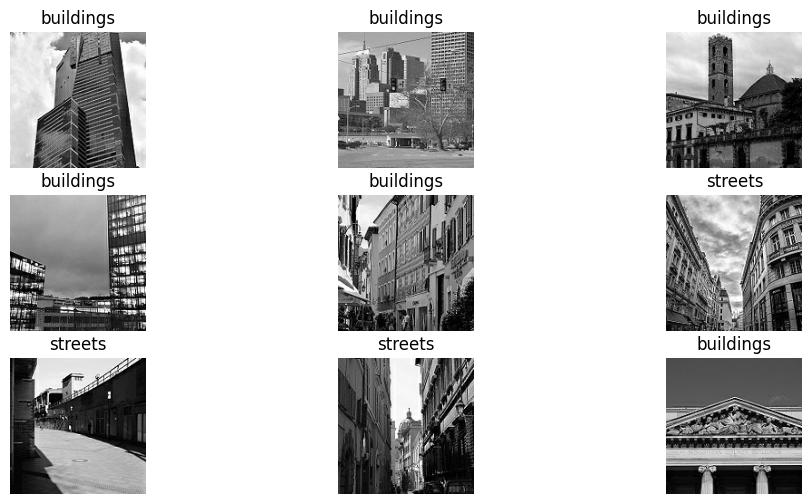

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for images in pred_ds.take(1):
    imgs = images.numpy()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(pred_labels[i])
    plt.axis('off')
plt.show()

In [100]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

IMG_H, IMG_W = 150, 150
class_names = ['streets', 'buildings']

def predict_image(image_path):
    # Load and preprocess image
    img = load_img(image_path, target_size=(IMG_H, IMG_W))
    img_array = img_to_array(img)
    img_array = tf.image.rgb_to_grayscale(img_array)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    pred_prob = model.predict(img_array)[0][0]
    pred_class = 1 if pred_prob >= 0.5 else 0
    print(f"Predicted class: {class_names[pred_class]} (probability: {pred_prob:.3f})")

# Example usage:
predict_image("/content/dataset/pred/pred/20677.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: buildings (probability: 0.666)
